<a href="https://colab.research.google.com/github/AaronLi/MacHacks-2/blob/main/Denatured_MacHacks2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
! pip install SmilesPE
! pip install --upgrade deepsmiles

import csv
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/inviand data/reaction_train_dataset.csv')
data

,reaction_id,reaction_smiles,mapped_reaction_smiles,ec_level_1,ec_level_2,ec_level_3,ec_level_4
0,28330,COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21.NCCCN...,[n:1]1[c:2]2[cH:3][cH:4][cH:5][cH:6][c:7]2[n+:...,1,1.5,1.5.99,1.5.99.6
1,6697,C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)...,[Fe+3:97].[Fe+3:98].[O:1]=[C:2]([CH3:3])[CH2:4...,1,1.3,1.3.2,1.3.2.3
2,33621,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:10][C:21](=[O:40])[S:60][CH2:16][CH2:15][...,2,2.3,2.3.1,2.3.1.5
3,37450,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)CCCC(=O)C(...,[CH2:1]([CH2:2][C:4]([C:6](=[O:10])[OH:11])=[O...,2,2.6,2.6.1,2.6.1.7
4,38912,CCCCCCCCC=CCCCCCCCC(=O)OCC(COP(=O)(O)OCCN)OC(=...,[CH3:1][CH2:3][CH2:5][CH2:7][CH2:9][CH2:11][CH...,3,3.1,3.1.4,3.1.4.4
...,...,...,...,...,...,...,...
35002,22681,CCC(C)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP...,[CH3:1][CH2:5][CH:14]([CH3:2])[C:25](=[O:38])[...,2,2.3,2.3.1,NaN
35003,55704,CCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCC.O>>CCCCCCC...,[CH3:2][CH2:4][CH2:6][CH2:8][CH2:10][CH2:12][C...,3,3.1,3.1.1,3.1.1.50
35004,33552,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:1][C:12](=[O:31])[S:51][CH2:7][CH2:6][NH:...,2,2.3,2.3.1,2.3.1.87
35005,46222,C#N.C=CC=O>>CC(C)[C@H](O)C#N,[CH2:1]=[CH:2][CH:3]=[O:4].[CH:5]#[N:6]>>[CH3:...,4,4.1,4.1.2,4.1.2.47


In [55]:
data.groupby('ec_level_1').count()

,reaction_id,reaction_smiles,mapped_reaction_smiles,ec_level_2,ec_level_3,ec_level_4
ec_level_1,,,,,,
1,10537,10537,10537,10530,10502,9745
2,9775,9775,9775,9775,9774,9068
3,9680,9680,9680,9680,9678,9425
4,2577,2577,2577,2577,2577,2423
5,885,885,885,885,884,828
6,1093,1093,1093,1093,1072,987
7,460,460,460,460,460,447


In [56]:
import codecs
from SmilesPE.tokenizer import *

spe_vob= codecs.open('/content/drive/MyDrive/inviand data/SPE_ChEMBL.txt')
spe = SPE_Tokenizer(spe_vob)

In [57]:
import re
splits = re.compile(r'>>|\.|,')
smiles_tokenized = []
for index, row in data.iterrows():
  tokenized = []
  components = splits.split(row.reaction_smiles)
  for component in components:
    tokenized.append(spe.tokenize(component).split(' '))
  smiles_tokenized.append(tokenized)
data['tokenized'] = smiles_tokenized
data

,reaction_id,reaction_smiles,mapped_reaction_smiles,ec_level_1,ec_level_2,ec_level_3,ec_level_4,tokenized
0,28330,COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21.NCCCN...,[n:1]1[c:2]2[cH:3][cH:4][cH:5][cH:6][c:7]2[n+:...,1,1.5,1.5.99,1.5.99.6,"[[CO, S(=O)(=O), [O-]], [C[n+]1, c2cccc, c2n, ..."
1,6697,C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)...,[Fe+3:97].[Fe+3:98].[O:1]=[C:2]([CH3:3])[CH2:4...,1,1.3,1.3.2,1.3.2.3,"[[C=, CC1, =C(C), c2cc3, [nH]c(, cc4, nc(, cc5..."
2,33621,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:10][C:21](=[O:40])[S:60][CH2:16][CH2:15][...,2,2.3,2.3.1,2.3.1.5,"[[CC(=O), S, CCNC(=O), CCNC(=O), [C@H](O), C(C..."
3,37450,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)CCCC(=O)C(...,[CH2:1]([CH2:2][C:4]([C:6](=[O:10])[OH:11])=[O...,2,2.6,2.6.1,2.6.1.7,"[[Nc1ccccc1, C(=O), C[C@H](N), C(=O)O], [O=C(O..."
4,38912,CCCCCCCCC=CCCCCCCCC(=O)OCC(COP(=O)(O)OCCN)OC(=...,[CH3:1][CH2:3][CH2:5][CH2:7][CH2:9][CH2:11][CH...,3,3.1,3.1.4,3.1.4.4,"[[CCCCCCCC, C=, CCCCCCCC, C(=O)OCC, (, CO, P(=..."
...,...,...,...,...,...,...,...,...
35002,22681,CCC(C)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP...,[CH3:1][CH2:5][CH:14]([CH3:2])[C:25](=[O:38])[...,2,2.3,2.3.1,NaN,"[[CCC(C), C(=O), S, CCNC(=O), CCNC(=O), [C@H](..."
35003,55704,CCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCC.O>>CCCCCCC...,[CH3:2][CH2:4][CH2:6][CH2:8][CH2:10][CH2:12][C...,3,3.1,3.1.1,3.1.1.50,"[[CCCCCCCCCCCCCCCC, OC(=O), CCCCCCCCCCCC, C], ..."
35004,33552,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:1][C:12](=[O:31])[S:51][CH2:7][CH2:6][NH:...,2,2.3,2.3.1,2.3.1.87,"[[CC(=O), S, CCNC(=O), CCNC(=O), [C@H](O), C(C..."
35005,46222,C#N.C=CC=O>>CC(C)[C@H](O)C#N,[CH2:1]=[CH:2][CH:3]=[O:4].[CH:5]#[N:6]>>[CH3:...,4,4.1,4.1.2,4.1.2.47,"[[C#N], [C=, CC, =O], [CC(C), [C@H](O), C#N]]"


In [58]:
symbol_dict = dict()
index = 0

for row in data.tokenized:
  #print(len(row))
  for reactant in row:
    for symbol in reactant:
      if symbol not in symbol_dict:
        index+=1
        symbol_dict[symbol]=index
sorted(symbol_dict)
symbol_dict['c6']
tokenLength = max(symbol_dict.values())
print(tokenLength)

2522


In [59]:
import numpy as np
smiles_onehot = []
for reaction in data.tokenized:
  reactionHot = []
  for molecule in reaction:
    moleculeHot=[]
    for token in molecule:
      # store as list of indexes
      index = symbol_dict[token]
      moleculeHot.append(index)
    reactionHot.append(moleculeHot)
  smiles_onehot.append(reactionHot)
data['OneHot'] = smiles_onehot
display(data)

,reaction_id,reaction_smiles,mapped_reaction_smiles,ec_level_1,ec_level_2,ec_level_3,ec_level_4,tokenized,OneHot
0,28330,COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21.NCCCN...,[n:1]1[c:2]2[cH:3][cH:4][cH:5][cH:6][c:7]2[n+:...,1,1.5,1.5.99,1.5.99.6,"[[CO, S(=O)(=O), [O-]], [C[n+]1, c2cccc, c2n, ...","[[1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 9], [11, ..."
1,6697,C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)...,[Fe+3:97].[Fe+3:98].[O:1]=[C:2]([CH3:3])[CH2:4...,1,1.3,1.3.2,1.3.2.3,"[[C=, CC1, =C(C), c2cc3, [nH]c(, cc4, nc(, cc5...","[[16, 17, 18, 19, 20, 21, 22, 23, 20, 24, 25, ..."
2,33621,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:10][C:21](=[O:40])[S:60][CH2:16][CH2:15][...,2,2.3,2.3.1,2.3.1.5,"[[CC(=O), S, CCNC(=O), CCNC(=O), [C@H](O), C(C...","[[45, 46, 47, 47, 48, 49, 1, 50, 51, 52, 53, 5..."
3,37450,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)CCCC(=O)C(...,[CH2:1]([CH2:2][C:4]([C:6](=[O:10])[OH:11])=[O...,2,2.6,2.6.1,2.6.1.7,"[[Nc1ccccc1, C(=O), C[C@H](N), C(=O)O], [O=C(O...","[[64, 65, 66, 67], [68, 69, 67], [70, 71, 67],..."
4,38912,CCCCCCCCC=CCCCCCCCC(=O)OCC(COP(=O)(O)OCCN)OC(=...,[CH3:1][CH2:3][CH2:5][CH2:7][CH2:9][CH2:11][CH...,3,3.1,3.1.4,3.1.4.4,"[[CCCCCCCC, C=, CCCCCCCC, C(=O)OCC, (, CO, P(=...","[[74, 16, 74, 75, 76, 1, 51, 77, 78, 79, 74, 8..."
...,...,...,...,...,...,...,...,...,...
35002,22681,CCC(C)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP...,[CH3:1][CH2:5][CH:14]([CH3:2])[C:25](=[O:38])[...,2,2.3,2.3.1,NaN,"[[CCC(C), C(=O), S, CCNC(=O), CCNC(=O), [C@H](...","[[617, 65, 46, 47, 47, 48, 49, 1, 50, 51, 52, ..."
35003,55704,CCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCC.O>>CCCCCCC...,[CH3:2][CH2:4][CH2:6][CH2:8][CH2:10][CH2:12][C...,3,3.1,3.1.1,3.1.1.50,"[[CCCCCCCCCCCCCCCC, OC(=O), CCCCCCCCCCCC, C], ...","[[309, 79, 195, 81], [13], [195, 108], [309, 13]]"
35004,33552,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:1][C:12](=[O:31])[S:51][CH2:7][CH2:6][NH:...,2,2.3,2.3.1,2.3.1.87,"[[CC(=O), S, CCNC(=O), CCNC(=O), [C@H](O), C(C...","[[45, 46, 47, 47, 48, 49, 1, 50, 51, 52, 53, 5..."
35005,46222,C#N.C=CC=O>>CC(C)[C@H](O)C#N,[CH2:1]=[CH:2][CH:3]=[O:4].[CH:5]#[N:6]>>[CH3:...,4,4.1,4.1.2,4.1.2.47,"[[C#N], [C=, CC, =O], [CC(C), [C@H](O), C#N]]","[[231], [16, 28, 15], [224, 48, 231]]"


In [60]:
data_y = np.zeros((len(data), 7))
for i, val in enumerate(data.ec_level_1):
  data_y[i][val-1] = 1
data_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [61]:
EC2_Class1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,97,1000] #1000 is used to catch ECs with no subclass
EC2_Class2 = [1,2,3,4,5,6,7,8,9,10,1000]
EC2_Class3 = [1,2,3,4,5,6,7,8,9,10,11,12,13,1000]
EC2_Class4 = [1,2,3,4,5,6,7,8,98,99,1000]
EC2_Class5 = [1,2,3,4,5,6,99,1000]
EC2_Class6 = [1,2,3,4,5,6,7,1000]
EC2_Class7 = [1,2,3,4,5,6,1000]

EC2 = [EC2_Class1,EC2_Class2,EC2_Class3,EC2_Class4,EC2_Class5,EC2_Class6,EC2_Class7] # general

EC2_Val = []
i=0
for i,row in enumerate(data.ec_level_2):
  #display("New row value: "+str(row))
  #display("Row index: "+str(i))
  i+=1
  try:
    [class1Num,class2Num] = str(row).split('.')
    class1Num = int(class1Num)
    class2Num = int(class2Num)
    #ecClass = row.split('.')
    #class1Num = int (row)
    #display("Class1Num: "+str(class1Num))
    #display("Onehot length:"+str(len(EC2[class1Num-1])))
  except:
    class1Num = int(data.ec_level_1[i])
    class2Num = int(1000)
  #onehot = np.zeros(1,len(EC2[class1Num-1]))
  #index = EC2[class1Num-1].index(class2Num)
  #onehot[index] = 1
  EC2_Val.append(class2Num)
data['EC2_Val'] = EC2_Val
data

,reaction_id,reaction_smiles,mapped_reaction_smiles,ec_level_1,ec_level_2,ec_level_3,ec_level_4,tokenized,OneHot,EC2_Val
0,28330,COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21.NCCCN...,[n:1]1[c:2]2[cH:3][cH:4][cH:5][cH:6][c:7]2[n+:...,1,1.5,1.5.99,1.5.99.6,"[[CO, S(=O)(=O), [O-]], [C[n+]1, c2cccc, c2n, ...","[[1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 9], [11, ...",5
1,6697,C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)...,[Fe+3:97].[Fe+3:98].[O:1]=[C:2]([CH3:3])[CH2:4...,1,1.3,1.3.2,1.3.2.3,"[[C=, CC1, =C(C), c2cc3, [nH]c(, cc4, nc(, cc5...","[[16, 17, 18, 19, 20, 21, 22, 23, 20, 24, 25, ...",3
2,33621,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:10][C:21](=[O:40])[S:60][CH2:16][CH2:15][...,2,2.3,2.3.1,2.3.1.5,"[[CC(=O), S, CCNC(=O), CCNC(=O), [C@H](O), C(C...","[[45, 46, 47, 47, 48, 49, 1, 50, 51, 52, 53, 5...",3
3,37450,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)CCCC(=O)C(...,[CH2:1]([CH2:2][C:4]([C:6](=[O:10])[OH:11])=[O...,2,2.6,2.6.1,2.6.1.7,"[[Nc1ccccc1, C(=O), C[C@H](N), C(=O)O], [O=C(O...","[[64, 65, 66, 67], [68, 69, 67], [70, 71, 67],...",6
4,38912,CCCCCCCCC=CCCCCCCCC(=O)OCC(COP(=O)(O)OCCN)OC(=...,[CH3:1][CH2:3][CH2:5][CH2:7][CH2:9][CH2:11][CH...,3,3.1,3.1.4,3.1.4.4,"[[CCCCCCCC, C=, CCCCCCCC, C(=O)OCC, (, CO, P(=...","[[74, 16, 74, 75, 76, 1, 51, 77, 78, 79, 74, 8...",1
...,...,...,...,...,...,...,...,...,...,...
35002,22681,CCC(C)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP...,[CH3:1][CH2:5][CH:14]([CH3:2])[C:25](=[O:38])[...,2,2.3,2.3.1,NaN,"[[CCC(C), C(=O), S, CCNC(=O), CCNC(=O), [C@H](...","[[617, 65, 46, 47, 47, 48, 49, 1, 50, 51, 52, ...",3
35003,55704,CCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCC.O>>CCCCCCC...,[CH3:2][CH2:4][CH2:6][CH2:8][CH2:10][CH2:12][C...,3,3.1,3.1.1,3.1.1.50,"[[CCCCCCCCCCCCCCCC, OC(=O), CCCCCCCCCCCC, C], ...","[[309, 79, 195, 81], [13], [195, 108], [309, 13]]",1
35004,33552,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,[CH3:1][C:12](=[O:31])[S:51][CH2:7][CH2:6][NH:...,2,2.3,2.3.1,2.3.1.87,"[[CC(=O), S, CCNC(=O), CCNC(=O), [C@H](O), C(C...","[[45, 46, 47, 47, 48, 49, 1, 50, 51, 52, 53, 5...",3
35005,46222,C#N.C=CC=O>>CC(C)[C@H](O)C#N,[CH2:1]=[CH:2][CH:3]=[O:4].[CH:5]#[N:6]>>[CH3:...,4,4.1,4.1.2,4.1.2.47,"[[C#N], [C=, CC, =O], [CC(C), [C@H](O), C#N]]","[[231], [16, 28, 15], [224, 48, 231]]",1


In [62]:
import functools
from tensorflow import keras
import tensorflow as tf
max_sequence_length = 0
continuous_onehots = []
for row in data['OneHot']:
  combined = np.array(functools.reduce(lambda a, b: a+b, row)).astype(float)
  continuous_onehots.append(combined)
  max_sequence_length = max(max_sequence_length, len(combined))
data_x = keras.preprocessing.sequence.pad_sequences(continuous_onehots, padding='post')
data_x

array([[  1,   2,   3, ...,   0,   0,   0],
       [ 16,  17,  18, ...,   0,   0,   0],
       [ 45,  46,  47, ...,   0,   0,   0],
       ...,
       [ 45,  46,  47, ...,   0,   0,   0],
       [231,  16,  28, ...,   0,   0,   0],
       [ 58,   1,  50, ...,   0,   0,   0]], dtype=int32)

In [63]:
def recall_m(y_true, y_pred):
  truePos = keras.metrics.Sum(tf.math.round(tf.experimental.numpy.clip(y_true*y_pred,0,1)))
  possiblePos = keras.metrics.Sum(tf.math.round(tf.experimental.numpy.clip(y_true,0,1)))
  recall = truePos/(possiblePos+keras.epsilon())
  return recall

def precision_m(y_true, y_pred):
  truePos = keras.metrics.Sum(tf.math.round(tf.experimental.numpy.clip(y_true*y_pred,0,1)))
  predPos = keras.metrics.Sum(tf.math.round(tf.experimental.numpy.clip(y_pred,0,1)))
  precision = truePos/(predPos+keras.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true,y_pred)
  f1 = 2*((precision*recall)/(precision+recall+keras.epsilon()))
  return f1

In [64]:
test_size = len(data_x)//10
shuffling = np.arange(len(data_x), dtype=int)
np.random.shuffle(shuffling)
data_x = data_x[shuffling]
data_y = data_y[shuffling]

test_x = data_x[:test_size]
train_x = data_x[test_size:]
test_y = data_y[:test_size]
train_y = data_y[test_size:]
#print(train_x.shape)
#print(train_y.shape)
#print(train_x[0])

In [65]:
model = keras.Sequential()

model.add(keras.layers.Embedding(input_dim=tokenLength, output_dim=4, mask_zero=True))
model.add(keras.layers.Dense(64, activation='selu'))
model.add(keras.layers.Dense(32, activation='selu'))
model.add(keras.layers.LSTM(32, dropout=0.3))
model.add(keras.layers.Dense(16, activation='selu'))
model.add(keras.layers.Dense(16, activation='selu'))
model.add(keras.layers.Dense(16, activation='selu'))
model.add(keras.layers.Dense(7, activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

model.summary()

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=32, epochs=10)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 4)           10088     
                                                                 
 dense_48 (Dense)            (None, None, 64)          320       
                                                                 
 dense_49 (Dense)            (None, None, 32)          2080      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 16)                272       
                                                                 
 dense_52 (Dense)            (None, 16)               

In [66]:
print(model(train_x[2:3]))
print(train_y[2])

tf.Tensor(
[[4.5076874e-04 5.0527728e-03 9.8402035e-01 4.1263187e-03 4.7324635e-03
  8.0707338e-07 1.6165803e-03]], shape=(1, 7), dtype=float32)
[0. 0. 1. 0. 0. 0. 0.]


In [69]:
display(history.history.keys())
recall_Class = history.history['val_recall_1'][-1]
precision_Class = history.history['val_precision_1'][-1]
accuracy_Class = history.history['val_accuracy'][-1]
f1_Class = 2*((precision_Class*recall_Class)/(precision_Class+recall_Class))
display("Final Class Recall:  "+str(recall_Class))
display("Final Class Accuracy:  "+str(accuracy_Class))
display("Final Class F1 Score:  "+str(f1_Class))
#padded_continuous[0]
#model.predict(padded_continuous)

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

'Final Class Recall:  0.8568571209907532'

'Final Class Accuracy:  0.87971431016922'

'Final Class F1 Score:  0.8790854468258757'

[[2.5719783e-04 4.8605129e-02 9.3712586e-01 3.4339314e-03 5.5644703e-03
  3.3855470e-06 5.0100633e-03]]
[0. 0. 1. 0. 0. 0. 0.]
dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])


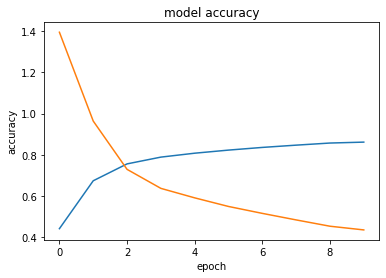

In [70]:
print(model.predict(test_x[0:1]))
print(test_y[0])

from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
## Code to predict subclasses, training sets
subClass1 = data[data['ec_level_1']==1]
display(subClass1)
subClass2 = data[data['ec_level_1']==2]
subClass3 = data[data['ec_level_1']==3]
subClass4 = data[data['ec_level_1']==4]
subClass5 = data[data['ec_level_1']==5]
subClass6 = data[data['ec_level_1']==6]
subClass7 = data[data['ec_level_1']==7]
subClassData = [subClass1,subClass2,subClass3,subClass4,subClass5,subClass6,subClass7]

subTrain_x = []
subTrain_y = []

for i, subData in enumerate(subClassData):
  # isolate x_data
  max_sub_sequence_length = 0
  continuous_onehots = []
  for row in subData['OneHot']:
   combined = np.array(functools.reduce(lambda a, b: a+b, row)).astype(float)
   continuous_onehots.append(combined)
   max_sub_sequence_length = max(max_sub_sequence_length, len(combined))
  subTrain_x.append(keras.preprocessing.sequence.pad_sequences(continuous_onehots, padding='post'))

  # isolate y_data
  temp_y = np.zeros((len(subData),len(EC2[i])))
  for row, val in enumerate(subData.EC2_Val):
    index = EC2[i].index(val)
    temp_y[row][index]=1

  #temp_y = np.array(subData.EC2_OneHot)
  subTrain_y.append(temp_y)

,reaction_id,reaction_smiles,mapped_reaction_smiles,ec_level_1,ec_level_2,ec_level_3,ec_level_4,tokenized,OneHot,EC2_Val
0,28330,COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21.NCCCN...,[n:1]1[c:2]2[cH:3][cH:4][cH:5][cH:6][c:7]2[n+:...,1,1.50,1.5.99,1.5.99.6,"[[CO, S(=O)(=O), [O-]], [C[n+]1, c2cccc, c2n, ...","[[1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 9], [11, ...",5
1,6697,C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)...,[Fe+3:97].[Fe+3:98].[O:1]=[C:2]([CH3:3])[CH2:4...,1,1.30,1.3.2,1.3.2.3,"[[C=, CC1, =C(C), c2cc3, [nH]c(, cc4, nc(, cc5...","[[16, 17, 18, 19, 20, 21, 22, 23, 20, 24, 25, ...",3
9,2278,*S[Fe]1(S[*+3])S[Fe](S*)([SH3+3]*)S1.CN1c2c([n...,[*:34][SH3+3:40][Fe:38]1([S:41][*:35])[S:42][F...,1,1.50,1.5.7,1.5.7.1,"[[*, S, [Fe], 1, (, S, [*+3], ), S, [Fe], (, S...","[[88, 46, 125, 126, 76, 46, 127, 92, 46, 125, ...",5
11,39246,*NC(=O)[C@H](CS)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C...,[C:12]([C@@H:13]1[CH2:14][CH2:15][CH2:16][N:31...,1,1.80,1.8.4,1.8.4.12,"[[*, NC(=O)[C@H](, CS), NC(=O)[C@@H]1, CCCN1C(...","[[88, 162, 90, 163, 164, 165, 162, 90, 70, 88,...",8
12,40236,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[CH:1]1=[CH:3][N:27]([C@H:20]2[C@H:15]([OH:31]...,1,1.14,1.14.12,1.14.12.12,"[[NC(=O), C1=C, N(, [C@@H]2, O[C@H](CO, P(=O)(...","[[174, 175, 176, 114, 115, 50, 51, 84, 116, 17...",14
...,...,...,...,...,...,...,...,...,...,...
34980,10635,NC(Cc1ccc(O)c(O)c1)C(=O)O.O.O=O>>N.O=C([O-])C(...,[cH:3]1[cH:4][c:9]([OH:13])[c:10]([OH:14])[cH:...,1,1.40,1.4.3,1.4.3.3,"[[NC(, Cc1ccc(, O)c(O), c1), C(=O)O], [O], [O,...","[[70, 265, 627, 684, 67], [13], [13, 15], [8],...",4
34981,7392,*N1c2cc(C)c(C)cc2Nc2c1[nH]c(=O)[nH]c2=O.C[C@]1...,[CH2:3]1[CH2:4][C:5](=[O:27])[CH:6]=[C:7]2[CH2...,1,1.14,1.14.14,1.14.14.14,"[[*, N1, c2cc(C), c(C), cc2, N, c2c1, [nH], c(...","[[88, 144, 243, 26, 244, 8, 245, 130, 142, 246...",14
34984,8580,C=C(CC[C@@H](C)[C@H]1CC[C@H]2C3=CC[C@H]4CC(=O)...,[CH3:1][CH:18]([CH3:2])[C:19](=[CH2:3])[CH2:7]...,1,1.10,1.1.1,NaN,"[[C=C(, CC[C@@H](C), [C@H]1CC[C@H]2, C3=, CC[C...","[[543, 454, 503, 563, 833, 45, 669, 922, 32, 5...",1
34989,57801,*.O=C(O)[C@H](O)CO>>O=C(O)C(=O)CO.[H]*[H],[*:8].[C:1]([C@@H:2]([CH2:3][OH:7])[OH:6])(=[O...,1,1.10,1.1.99,1.1.99.6,"[[*], [O=C(O), [C@H](O), CO], [O=C(O), C(=O), ...","[[88], [68, 48, 1], [68, 65, 1], [102, 88, 102]]",1


Epoch 1/10
297/297 [==============================] - 19s 45ms/step - loss: 2.2418 - accuracy: 0.3209 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.1088 - val_accuracy: 0.3115 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
297/297 [==============================] - 11s 38ms/step - loss: 2.0395 - accuracy: 0.3220 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.0627 - val_accuracy: 0.3115 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
297/297 [==============================] - 12s 39ms/step - loss: 2.0098 - accuracy: 0.3368 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.0253 - val_accuracy: 0.3286 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
297/297 [==============================] - 12s 39ms/step - loss: 1.9184 - accuracy: 0.4283 - Precision: 0.8248 - Recall: 0.0665 - val_loss: 1.8542 - val_accuracy: 0.4786 - val_Precision: 0.8199 - val_Recall: 0.2422
Epoch 5/10
297/297 [============================

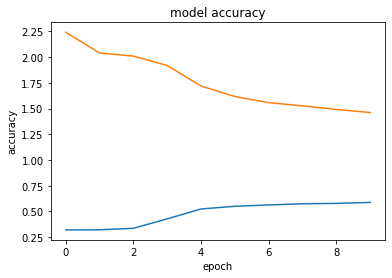

Epoch 1/10
275/275 [==============================] - 19s 39ms/step - loss: 1.9123 - accuracy: 0.2674 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.7951 - val_accuracy: 0.2927 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
275/275 [==============================] - 9s 32ms/step - loss: 1.5288 - accuracy: 0.4242 - Precision: 0.7168 - Recall: 0.1321 - val_loss: 1.3284 - val_accuracy: 0.5005 - val_Precision: 0.7944 - val_Recall: 0.1464
Epoch 3/10
275/275 [==============================] - 9s 32ms/step - loss: 1.2648 - accuracy: 0.5311 - Precision: 0.7182 - Recall: 0.2063 - val_loss: 1.1300 - val_accuracy: 0.6121 - val_Precision: 0.7073 - val_Recall: 0.3685
Epoch 4/10
275/275 [==============================] - 9s 32ms/step - loss: 1.1381 - accuracy: 0.5788 - Precision: 0.7039 - Recall: 0.4186 - val_loss: 1.1273 - val_accuracy: 0.5763 - val_Precision: 0.6389 - val_Recall: 0.4166
Epoch 5/10
275/275 [==============================] - 9s 32ms/step - loss: 1.0381 -

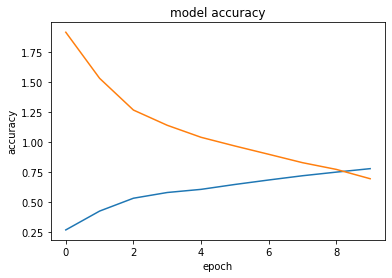

Epoch 1/10
273/273 [==============================] - 15s 37ms/step - loss: 1.7771 - accuracy: 0.2772 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.5950 - val_accuracy: 0.2614 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
273/273 [==============================] - 8s 30ms/step - loss: 1.5472 - accuracy: 0.3729 - Precision: 1.0000 - Recall: 0.0032 - val_loss: 1.3891 - val_accuracy: 0.5124 - val_Precision: 1.0000 - val_Recall: 0.0661
Epoch 3/10
273/273 [==============================] - 9s 32ms/step - loss: 1.3170 - accuracy: 0.5308 - Precision: 0.8744 - Recall: 0.1422 - val_loss: 1.1444 - val_accuracy: 0.6260 - val_Precision: 0.8946 - val_Recall: 0.2893
Epoch 4/10
273/273 [==============================] - 8s 30ms/step - loss: 1.1259 - accuracy: 0.6342 - Precision: 0.8138 - Recall: 0.3838 - val_loss: 0.9856 - val_accuracy: 0.6829 - val_Precision: 0.8427 - val_Recall: 0.4814
Epoch 5/10
273/273 [==============================] - 8s 31ms/step - loss: 0.9057 -

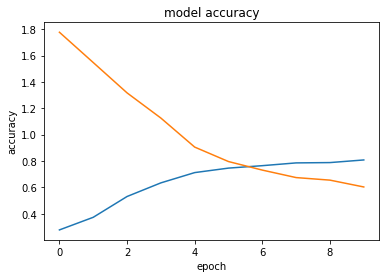

Epoch 1/10
73/73 [==============================] - 9s 54ms/step - loss: 1.6452 - accuracy: 0.3970 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.4244 - val_accuracy: 0.4397 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
73/73 [==============================] - 2s 28ms/step - loss: 1.4008 - accuracy: 0.4310 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.3829 - val_accuracy: 0.4436 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
73/73 [==============================] - 2s 28ms/step - loss: 1.3757 - accuracy: 0.4634 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.3725 - val_accuracy: 0.4981 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
73/73 [==============================] - 2s 27ms/step - loss: 1.3644 - accuracy: 0.4797 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.3620 - val_accuracy: 0.5253 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 5/10
73/73 [==========================

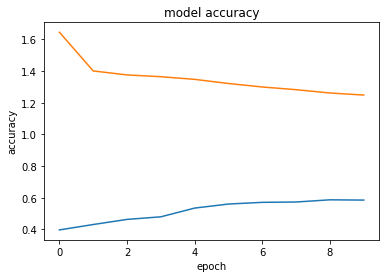

Epoch 1/10
25/25 [==============================] - 9s 111ms/step - loss: 1.9024 - accuracy: 0.2535 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.8155 - val_accuracy: 0.2273 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 1s 30ms/step - loss: 1.7618 - accuracy: 0.2622 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.7083 - val_accuracy: 0.2273 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
25/25 [==============================] - 1s 29ms/step - loss: 1.6953 - accuracy: 0.2434 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.6515 - val_accuracy: 0.2386 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 1s 31ms/step - loss: 1.6615 - accuracy: 0.2509 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.6299 - val_accuracy: 0.2386 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 5/10
25/25 [=========================

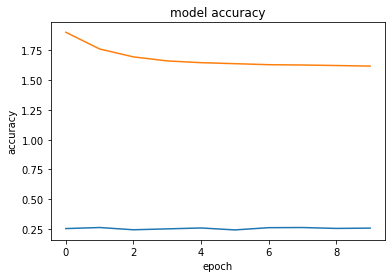

Epoch 1/10
31/31 [==============================] - 8s 96ms/step - loss: 1.2961 - accuracy: 0.6504 - Precision: 0.6560 - Recall: 0.4573 - val_loss: 1.1867 - val_accuracy: 0.6606 - val_Precision: 0.6606 - val_Recall: 0.6606
Epoch 2/10
31/31 [==============================] - 1s 31ms/step - loss: 1.0352 - accuracy: 0.6606 - Precision: 0.6612 - Recall: 0.6585 - val_loss: 1.1258 - val_accuracy: 0.6606 - val_Precision: 0.6606 - val_Recall: 0.6606
Epoch 3/10
31/31 [==============================] - 1s 32ms/step - loss: 0.9790 - accuracy: 0.6606 - Precision: 0.6606 - Recall: 0.6606 - val_loss: 1.1195 - val_accuracy: 0.6606 - val_Precision: 0.6606 - val_Recall: 0.6606
Epoch 4/10
31/31 [==============================] - 1s 32ms/step - loss: 0.9625 - accuracy: 0.6606 - Precision: 0.6606 - Recall: 0.6606 - val_loss: 1.1024 - val_accuracy: 0.6606 - val_Precision: 0.6606 - val_Recall: 0.6606
Epoch 5/10
31/31 [==============================] - 1s 31ms/step - loss: 0.9533 - accuracy: 0.6606 - Precisi

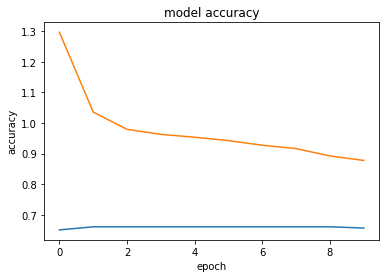

Epoch 1/10
13/13 [==============================] - 7s 196ms/step - loss: 1.7075 - accuracy: 0.5507 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.6949 - val_accuracy: 0.4565 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
13/13 [==============================] - 0s 37ms/step - loss: 1.5058 - accuracy: 0.5676 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.6479 - val_accuracy: 0.4565 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
13/13 [==============================] - 0s 37ms/step - loss: 1.4342 - accuracy: 0.5676 - Precision: 0.5978 - Recall: 0.1329 - val_loss: 1.6168 - val_accuracy: 0.4565 - val_Precision: 0.4667 - val_Recall: 0.4565
Epoch 4/10
13/13 [==============================] - 0s 37ms/step - loss: 1.4050 - accuracy: 0.5676 - Precision: 0.5593 - Recall: 0.4444 - val_loss: 1.5912 - val_accuracy: 0.4565 - val_Precision: 0.4565 - val_Recall: 0.4565
Epoch 5/10
13/13 [==============================] - 1s 41ms/step - loss: 1.

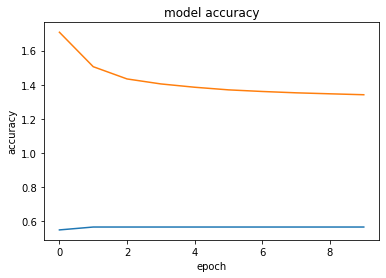

In [73]:
models = []
subHistory = []
from matplotlib import pyplot as plt
for subclass_info, subclass_data, subclass_labels in zip(EC2, subTrain_x, subTrain_y):
  model_output_width = len(subclass_info)
  sub_model = keras.Sequential()

  sub_model.add(keras.layers.Embedding(input_dim=tokenLength, output_dim=4, mask_zero=True))
  sub_model.add(keras.layers.Dense(64, activation='selu'))
  sub_model.add(keras.layers.Dense(32, activation='selu'))
  sub_model.add(keras.layers.LSTM(32, dropout=0.3))
  sub_model.add(keras.layers.Dense(16, activation='selu'))
  sub_model.add(keras.layers.Dense(16, activation='selu'))
  sub_model.add(keras.layers.Dense(16, activation='selu'))
  sub_model.add(keras.layers.Dense(model_output_width, activation='softmax'))

  sub_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy',tf.keras.metrics.Precision(name='Precision'),tf.keras.metrics.Recall(name='Recall')])
  
  subclass_shuffling = np.arange(len(subclass_data))

  np.random.shuffle(subclass_shuffling)

  take_amount = len(subclass_data)//10

  shuffled_data = subclass_data[subclass_shuffling]
  shuffled_labels = subclass_labels[subclass_shuffling]

  subclass_test_x, subclass_train_x = shuffled_data[:take_amount], shuffled_data[take_amount:]
  subclass_test_y, subclass_train_y = shuffled_labels[:take_amount], shuffled_labels[take_amount:]

  #print(subclass_train_x.shape, subclass_train_y.shape)
  
  #print(subTrain_x[0][:10])
  #print(subTrain_y[0][:10])
  history = sub_model.fit(subclass_train_x, subclass_train_y, validation_data=(subclass_test_x, subclass_test_y), batch_size=32, epochs=10)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['loss'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  #plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  models.append(sub_model)
  subHistory.append(history.history)


In [74]:
epsilon = 1e-07 # small constant to prevent zero division in F1 calculation
#display(subHistory)
accuracies = []
precisions = []
f1=[]

for his in subHistory:
  accuracies.append((his['val_accuracy'])[-1])
  precisions.append((his['val_Precision'])[-1])
  f1.append(2*(((his['val_Precision'])[-1]*(his['val_Recall'])[-1])/((his['val_Precision'])[-1]+(his['val_Recall'])[-1]+epsilon)))

sR = {'Classes': [1,2,3,4,5,6,7], 'Accuracies': accuracies,'Precisions': precisions, 'F1' : f1}
subResults = pd.DataFrame(sR)
display(subResults)

,Classes,Accuracies,Precisions,F1
0,1,0.598291,0.760274,0.542456
1,2,0.798362,0.837288,0.795918
2,3,0.806818,0.837748,0.810032
3,4,0.575875,0.618280,0.519187
4,5,0.193182,0.000000,0.000000
5,6,0.660550,0.929577,0.733333
6,7,0.456522,0.456522,0.456522


In [75]:
def cleanSmiles(smiles, dict): # pass in smiles string and dictionary of tokens
  splits = re.compile(r'>>|\.|,')
  tokenized = []
  components = splits.split(smiles)
  for component in components:
    temp = spe.tokenize(component).split(' ')
    if len(temp) > 1:
      for segment in temp:
        tokenized.append(segment)
  # now tokenized

  #display(components)
  reaction_hot = []
  for token in tokenized:
    index = dict[str(token)]
    #print(index)
    reaction_hot.append(index)
  combined = np.array(reaction_hot)
  return keras.preprocessing.sequence.pad_sequences([combined], padding='post', maxlen=max_sequence_length)[0].reshape((1, -1))

In [76]:
def predict_enzyme(smiles):
  input_vec = cleanSmiles(smiles, symbol_dict)
  ec_1 = model(input_vec, training=False)[0]#model(input_vec)
  choice_ec1 = list(ec_1).index(max(ec_1))
  #print(ec_1)
  #print('evaluating:', list(input_vec), 'result:', ec_1.numpy().tolist())
  # for i, result in enumerate(ec_1):
  #   if result > ec_1[choice_ec1]:
  #     #print(i, result, '>', ec_1[choice_ec1])
  #     choice_ec1 = i
  
  ec_2 = models[choice_ec1](input_vec)[0]
  #print(ec_2)
  choice_ec2 = list(ec_2).index(max(ec_2))
  # for i, result in enumerate(ec_2):
  #   if result > ec_2[choice_ec2]:
  #     choice_ec2 = i
  return choice_ec1+1, choice_ec2+1




In [77]:
test_data = pd.read_csv('/content/drive/MyDrive/inviand data/reaction_test_dataset.csv')
test_data

,reaction_id,reaction_smiles,mapped_reaction_smiles,ec_level_1,ec_level_2,ec_level_3,ec_level_4
0,48567,CCCCC[C@H](O)c1c(O)cc2c(c1O)C(=O)c1c(O)cc(O)cc...,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:12]([...,1,1.14,1.14.14,1.14.14.116
1,68073,C=CC(CC#N)OCc1ccccc1.O>>C=CC(CC(N)=O)OCc1ccccc1,[CH2:1]=[CH:2][CH:12]([CH2:8][C:9]#[N:13])[O:1...,4,4.20,4.2.1,4.2.1.84
2,55632,CSCC[C@H](NC(C)=O)C(=O)Nc1ccc2c(C)cc(=O)oc2c1....,[CH3:1][c:10]1[cH:8][c:16](=[O:21])[o:23][c:15...,3,3.40,3.4.19,3.4.19.1
3,65201,CN[C@@H]1[C@H](O[C@H]2[C@H](O[C@@H]3[C@@H](NC(...,[CH2:44]([C@@H:47]1[C@@H:49]([OH:59])[C@@H:50]...,2,2.70,2.7.1,2.7.1.72
4,27225,O.O=C1CCC(C(=O)O)=CN1>>N.N/C(=C\CC(=O)O)C(=O)O,[CH2:1]1[CH2:2][C:5](=[O:8])[NH:7][CH:3]=[C:4]...,3,3.50,3.5.2,3.5.2.18
...,...,...,...,...,...,...,...
3885,25173,O.O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2OP(=...,[cH:1]1[cH:2][n:11]([C@H:8]2[C@H:7]([O:20][P:2...,3,3.10,3.1.3,3.1.3.31
3886,20383,*N1c2cc(C)c(C)cc2Nc2c1[nH]c(=O)[nH]c2=O.O=O.O=...,[*:1][N:2]1[c:3]2[cH:4][c:5]([CH3:19])[c:6]([C...,1,1.14,1.14.14,1.14.14.M29
3887,46359,*OC[C@H]1O[C@H](OC[C@H]2O[C@H](OC[C@H]3O[C@H](...,[C@@H:1]1([O:31][CH2:12][C@@H:11]2[C@@H:10]([O...,3,3.20,3.2.1,3.2.1.11
3888,8622,*.O.O=C(O)CCC(=O)c1cccnc1>>O=C(O)CCC(=O)c1ccc(...,[*:14].[C:1]([CH2:2][CH2:3][C:4]([c:5]1[cH:6][...,1,1.50,1.5.99,NaN


In [78]:
from collections import defaultdict
true_positives = defaultdict(int)
false_positives = defaultdict(int)
false_negatives = defaultdict(int)

true_positives_ec1 = defaultdict(int)
false_positives_ec1 = defaultdict(int)
false_negatives_ec1 = defaultdict(int)
checked = 0
for i, row in test_data[['reaction_smiles', 'ec_level_1', 'ec_level_2']].iterrows():
  try:
    predict_ec_1, predict_ec_2 = list(map(str, predict_enzyme(row.reaction_smiles)))
    ec_l2 = str(row.ec_level_2)
    ec_1, ec_2 = ec_l2.split('.')

    predict_class = f"{predict_ec_1}.{predict_ec_2}"

    if ec_l2 == predict_class:
        true_positives[ec_l2] += 1
    else:
      false_negatives[ec_l2] += 1
      false_positives[predict_class] += 1

    if predict_ec_1 == ec_1:
      true_positives_ec1[ec_l2] += 1
    else:
      false_positives_ec1[predict_ec_1] += 1
      false_negatives_ec1[ec_1] += 1

    checked += 1
  except:
    pass
print(true_positives, false_positives, false_negatives,checked,sep="\n"+'*'*20+"\n")
  
print(row.reaction_smiles, row.ec_level_2)

defaultdict(<class 'int'>, {'3.4': 284, '2.7': 164, '1.1': 246, '2.3': 165, '6.3': 77, '1.14': 217, '2.8': 30, '2.1': 107, '2.5': 57, '2.6': 54, '4.2': 37, '3.2': 203, '3.5': 64, '2.4': 207, '4.1': 73, '3.1': 117, '1.13': 21, '7.6': 9, '1.3': 4, '1.11': 1})
********************
defaultdict(<class 'int'>, {'1.1': 344, '4.1': 253, '2.6': 79, '2.5': 53, '4.2': 66, '1.14': 126, '3.4': 70, '2.7': 107, '3.5': 71, '2.3': 58, '3.2': 68, '2.4': 116, '3.1': 90, '1.13': 58, '5.1': 37, '2.8': 9, '1.11': 3, '1.3': 25, '6.3': 72, '2.1': 7, '7.6': 10, '5.3': 4})
********************
defaultdict(<class 'int'>, {'1.14': 125, '4.2': 82, '3.5': 154, '1.4': 58, '2.3': 64, '1.17': 26, '1.1': 81, '1.2': 63, '2.4': 49, '5.3': 32, '1.5': 52, '4.4': 26, '1.21': 16, '3.1': 115, '1.3': 97, '3.6': 35, '2.7': 61, '1.11': 32, '1.13': 46, '2.8': 31, '4.1': 35, '3.4': 25, '3.2': 40, '1.6': 15, '6.2': 24, '4.3': 20, '1.8': 28, '2.6': 15, '1.7': 22, '2.5': 49, '4.7': 1, '1.12': 5, '7.6': 18, '2.1': 14, '6.1': 9, '7.4':

In [79]:

true_positive_sum = sum(true_positives.values())
false_positive_sum = sum(false_positives.values())
false_negative_sum = sum(false_negatives.values())
precision = true_positive_sum / (true_positive_sum + false_positive_sum)
recall = true_positive_sum / (true_positive_sum + false_negative_sum)
f1 = (2*precision *recall)/(precision+recall)
print(precision, recall, f1)

true_positive_sum_ec1 = sum(true_positives_ec1.values())
false_positive_sum_ec1 = sum(false_positives_ec1.values())
false_negative_sum_ec1 = sum(false_negatives_ec1.values())
precision_ec1 = true_positive_sum_ec1 / (true_positive_sum_ec1 + false_positive_sum_ec1)
recall_ec1 = true_positive_sum_ec1 / (true_positive_sum_ec1 + false_negative_sum_ec1)
f1_ec1 = (2*precision_ec1 * recall_ec1) / (precision_ec1+recall_ec1)
print(precision_ec1, recall_ec1, f1_ec1)

0.5531969971524722 0.5531969971524722 0.5531969971524722
0.7903184053844162 0.7903184053844162 0.7903184053844162


In [80]:
precisions = []
recalls = []
all_classes = set(true_positives.keys())|set(false_positives.keys())|set(false_negatives.keys())
num_classes = len(all_classes)
for cls in all_classes:
  try:
    precisions.append(true_positives[cls] / (true_positives[cls] +false_positives[cls]))
    recalls.append(true_positives[cls] / (true_positives[cls] +false_negatives[cls]))
  except ZeroDivisionError:
    pass
print(len(precisions), len(recalls), num_classes)
totalSize = checked # number of test cases checked
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)
f1 = (2*precision*recall)/(precision+recall)
accuracy = true_positive_sum/totalSize
print('ec1+ec2: precision:', precision, 'accuracy:', accuracy, 'f1:', f1)


22 22 61
ec1+ec2: precision: 0.47661657483797576 accuracy: 0.5531969971524722 f1: 0.4984528612263456


In [81]:
precisions_ec1 = []
recalls_ec1 = []
all_classes_ec1 = set(true_positives_ec1.keys())|set(false_positives_ec1.keys())|set(false_negatives_ec1.keys())
num_classes_ec1 = len(all_classes_ec1)
for cls in all_classes_ec1:
  try:
    precisions_ec1.append(true_positives_ec1[cls] / (true_positives_ec1[cls] +false_positives_ec1[cls]))
    recalls_ec1.append(true_positives_ec1[cls] / (true_positives_ec1[cls] +false_negatives_ec1[cls]))
  except ZeroDivisionError:
    pass
print(len(precisions_ec1), len(recalls_ec1), num_classes_ec1)
precision_ec1 = sum(precisions_ec1)/len(precisions_ec1)
recall_ec1 = sum(recalls_ec1)/len(recalls_ec1)
f1_ec1 = (2*precision_ec1*recall_ec1)/(precision_ec1+recall_ec1)
accuracy_ec1 = true_positive_sum_ec1/totalSize
print('ec1: precision:', precision_ec1, 'accuracy:', accuracy_ec1, 'f1:', f1_ec1)

58 58 58
ec1: precision: 0.8793103448275862 accuracy: 0.7903184053844162 f1: 0.8793103448275863
